## Analyze simulation outputs.

/tmp/ipykernel_115233/1670354821.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.vectors_numerical = np.array(self.vectors_numerical)


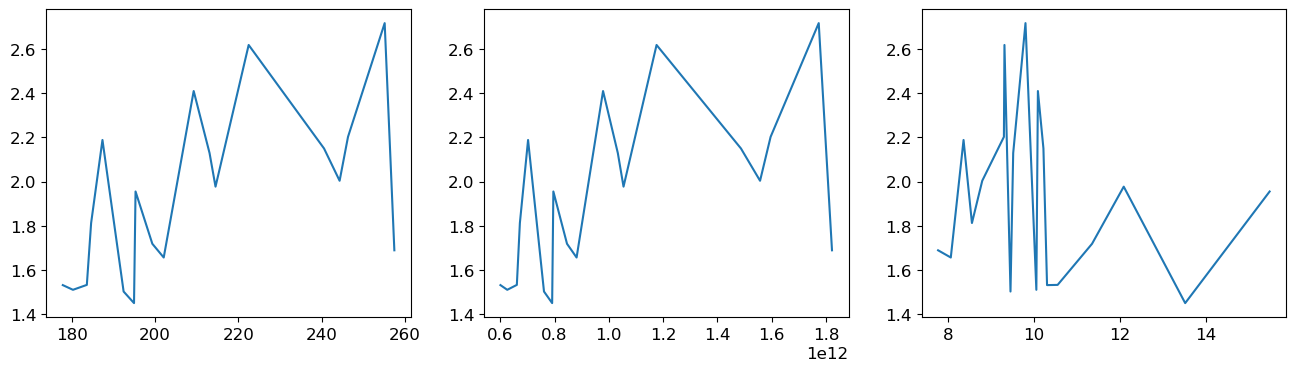

In [10]:
from shared.preface import *
from shared.shared_functions import *
from shared.plot_class import analyze_simulation_outputs
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

class analyze_simulation_outputs_test(object):

    def __init__(self, sim_dir, objects, sim_type):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        self.sim_type = sim_type
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)

        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])
        self.halo_indices = np.load(
            glob.glob(f'{self.sim_dir}/halo_batch*indices.npy')[0]
        )
        self.halo_params = np.load(
            glob.glob(f'{self.sim_dir}/halo_batch*params.npy')[0]
        )
        halo_num = len(self.halo_params)
        halo_num = 19  #! testing

        if self.sim_type == 'single_halos':

            if 'NFW_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
                )
                
                self.vectors_benchmark = []
                for batch_path in batch_paths:
                    self.vectors_benchmark.append(np.load(batch_path))
                self.vectors_benchmark = np.squeeze(
                    np.array(self.vectors_benchmark)
                )
                self.vectors_benchmark = np.array(self.vectors_benchmark)

                self.etas_benchmark = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo.npy'
                )/N0


            if 'box_halos' in self.objects:
                
                self.etas_numerical = []
                self.vectors_numerical = []

                for halo in range(1, halo_num+1): 
                    
                    # Find all batch paths belonging to current halo.
                    batch_paths = glob.glob(
                        f'{self.sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                    )

                    # Concatenate all vector batches into one array.
                    vectors_halo = []
                    for batch_path in batch_paths:
                        vectors_halo.append(np.load(batch_path))
                    vectors_halo = np.squeeze(np.array(vectors_halo))

                    # Append vectors.
                    self.vectors_numerical.append(vectors_halo)

                    # Append overdensities.
                    self.etas_numerical.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}.npy'
                        )/N0
                    )

                self.etas_numerical = np.array(self.etas_numerical)
                self.vectors_numerical = np.array(self.vectors_numerical)


            if 'analytical_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_analytical_batch*.npy'
                )
                
                self.vectors_analytical = []
                for batch_path in batch_paths:
                    self.vectors_analytical.append(np.load(batch_path))
                self.vectors_analytical = np.squeeze(
                    np.array(self.vectors_analytical)
                )
                self.vectors_analytical = np.array(self.vectors_analytical)

                self.etas_analytical = np.load(
                    f'{self.sim_dir}/number_densities_analytical_single_halos.npy'
                )/N0


        elif self.sim_type == 'all_sky':

            if 'box_halos' in self.objects:

                self.number_densities_numerical_all_sky = []

                for halo in range(1, halo_num+1):
                    
                    # Append overdensities.
                    self.number_densities_numerical_all_sky.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}_all_sky.npy'
                        )
                    )

                self.number_densities_numerical_all_sky = np.array(
                    self.number_densities_numerical_all_sky
                )


            if 'NFW_halo' in self.objects:

                self.number_densities_numerical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo_all_sky.npy'
                )[np.newaxis,...]


            if 'analytical_halo' in self.objects:

                self.number_densities_analytical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_analytical_all_sky.npy'
                )


    def rotate_DM(self, DM_pos, obs_pos):

        # Calculate the Euler angles, to match frame of Earth. This will be the 
        # new frame in which DM particles get projected to an all sky map.
        zAngle = np.arctan2(obs_pos[1], -obs_pos[0])
        yAngle = np.arctan2(-obs_pos[2], np.linalg.norm(obs_pos[:2]))
        # print('*** Angles: ***')
        # print(np.rad2deg(zAngle), np.rad2deg(yAngle))

        cz = np.cos(zAngle)
        sz = np.sin(zAngle)
        cy = np.cos(yAngle)
        sy = np.sin(yAngle)

        R_z = np.array([
            [cz, -sz, 0],
            [sz, cz,  0],
            [0,  0,   1]
        ])
        R_y = np.array([
            [cy,  0, sy],
            [0,   1,  0],
            [-sy, 0, cy]
        ])

        rot_mat = np.matmul(R_y, R_z)

        # Observer position in nex frame (aligned with x-axis).
        obs_orig_in_rot_frame = np.matmul(rot_mat, obs_pos.T).T

        # Dark matter positions in observer frame.
        DM_orig_in_rot_frame = np.matmul(rot_mat, DM_pos.T).T

        return DM_orig_in_rot_frame, obs_orig_in_rot_frame


    def rot_int_smooth_healpix_map(self, healpix_map, cell0):
        
        # Angles to compensate for location of starting cell (cell0).
        zAngle = np.rad2deg(np.arctan2(cell0[1], -cell0[0]))
        yAngle = np.rad2deg(np.arctan2(-cell0[2], np.linalg.norm(cell0[:2])))

        # Create rotator object, to place c.o.p. of halo in the map center.
        rot = hp.rotator.Rotator(
            rot=[-zAngle, yAngle, 0], deg=True, eulertype='ZYX', inv=False
        )

        # Create a grid of (theta, phi) coordinates for the map.
        Nside = hp.npix2nside(len(healpix_map))
        theta, phi = hp.pix2ang(Nside, np.arange(len(healpix_map)))

        # Apply rotation to the grid.
        theta_rot, phi_rot = rot(theta, phi)

        # Find the pixel indices of the rotated grid.
        pix_rot = hp.ang2pix(Nside, theta_rot, phi_rot)

        # Create a new map with rotated pixel values.
        rotated_map = np.zeros_like(healpix_map)
        rotated_map[pix_rot] = healpix_map

        # Interpolate zero pixels with values from 4 neighbours.
        zero_pixels = np.where(rotated_map == 0)[0]
        for pix in zero_pixels:
            theta_zero, phi_zero = hp.pix2ang(Nside, pix)
            interp_val = hp.get_interp_val(
                healpix_map, theta_zero, phi_zero
            )
            rotated_map[pix] = interp_val

        # Smooth the rotated map using a Gaussian kernel.
        reso_1pix_deg = hp.nside2resol(Nside, arcmin=True) / 60
        sigma_rad = np.deg2rad(reso_1pix_deg/2.)
        smooth_rot_map = hp.smoothing(rotated_map, sigma=sigma_rad)

        return smooth_rot_map


    def plot_all_sky_map(
            self, nu_mass_eV, sim_method, halo=None, two_plots=False
        ):

        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        # Automatic.
        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        healpy_dict = dict(
            coord=['G'],
            graticule=True,
            graticule_labels=True,
            xlabel="longitude",
            ylabel="latitude",
            cb_orientation="horizontal",
            projection_type="mollweide",
            flip='astro',
            latitude_grid_spacing=45,
            longitude_grid_spacing=45,
            phi_convention='counterclockwise',
        )

        if sim_method == 'analytical':

            dens_nu = self.number_densities_analytical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu/N0_pix

            healpix_map = etas_nu

            # Create a grid of (theta, phi) coordinates for the map
            theta, phi = hp.pix2ang(Nside, np.arange(len(healpix_map)))

            # Rotation for Virgo Cluster.
            # VCzAngle = np.rad2deg(
            #     np.arctan2(X_VC[1], -X_VC[0])
            # )
            # VCyAngle = np.rad2deg(
            #     np.arctan2(-X_VC[2], np.linalg.norm(X_VC[:2]))
            # )
            # rot = hp.rotator.Rotator(
            #     rot=[0, 90, 0], deg=True, eulertype='ZYX', inv=False
            # )

            # Rotation for Milky Way only.
            rot = hp.rotator.Rotator(
                rot=[-180, 0, 0], deg=True, eulertype='ZYX', inv=False
            )

            # Apply rotation to the grid
            theta_rot, phi_rot = rot(theta, phi)

            # Find the pixel indices of the rotated grid
            pix_rot = hp.ang2pix(Nside, theta_rot, phi_rot)

            # Create a new map with rotated pixel values
            rotated_map = np.zeros_like(healpix_map)
            rotated_map[pix_rot] = healpix_map

            # Find zero-valued pixels and interpolate their values from 4 neighbors
            zero_pixels = np.where(rotated_map == 0)[0]
            for pix in zero_pixels:
                theta_zero, phi_zero = hp.pix2ang(Nside, pix)
                interp_val = hp.get_interp_val(
                    healpix_map, theta_zero, phi_zero
                )
                rotated_map[pix] = interp_val

            hp.newvisufunc.projview(
                rotated_map,
                coord=['G'],
                title=f'Analytical (Npix={Npix})',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro',
                # cbar_ticks=[],
                show_tickmarkers=True,
                latitude_grid_spacing=45,
                longitude_grid_spacing=45,
                alpha=1,
                phi_convention='counterclockwise',
                # min=0.7,
                # max=5.5
            )

            plt.savefig(
                f'{self.fig_dir}/All_sky_map_analytical_{nu_mass_eV}eV.pdf', 
                bbox_inches='tight'
            )
            plt.show()
            plt.close()

            return healpix_map

        if sim_method == 'numerical':

            fig = plt.figure(figsize =(12, 4.4))
            fig.tight_layout()

            if two_plots:

                # Axis 1 params.
                ax1 = fig.add_subplot(121)
                ax1.spines['top'].set_visible(False)
                ax1.spines['right'].set_visible(False)
                ax1.spines['bottom'].set_visible(False)
                ax1.spines['left'].set_visible(False)
                ax1.get_xaxis().set_ticks([])
                ax1.get_yaxis().set_ticks([])
                subax1 = 121

                # Axis 2 params.
                # ax2 = fig.add_subplot(122, projection='3d')
                ax2 = fig.add_subplot(122)
                ax2.spines['top'].set_visible(False)
                ax2.spines['right'].set_visible(False)
                ax2.spines['bottom'].set_visible(False)
                ax2.spines['left'].set_visible(False)
                ax2.get_xaxis().set_ticks([])
                ax2.get_yaxis().set_ticks([])
                subax2 = 122

            else:

                ax1 = fig.add_subplot(111)
                ax1.spines['top'].set_visible(False)
                ax1.spines['right'].set_visible(False)
                ax1.spines['bottom'].set_visible(False)
                ax1.spines['left'].set_visible(False)
                ax1.get_xaxis().set_ticks([])
                ax1.get_yaxis().set_ticks([])
                subax1 = 111

            if halo == 0:
                end_str = f'benchmark_halo'
            else:
                end_str = f'halo{halo}'

            init_xyz = np.load(f'{self.sim_dir}/init_xyz_{end_str}.npy')
            # print(f'*** Initial cell coordinates: ***')
            # print(init_xyz)
            # print(np.linalg.norm(init_xyz))
            # print(f'*** ========================= ***')

            
            # Get number densities and convert to clustering factors.
            dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu/N0_pix

            # Select halo.
            etas_halo = etas_nu[halo-1,...]
            
            healpix_map = self.rot_int_smooth_healpix_map(etas_halo, init_xyz)

            # Make center value to be 1 (no overdensity).
            divnorm = mcolors.TwoSlopeNorm(vcenter=1.)
            hp.newvisufunc.projview(
                healpix_map, unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1,
                override_plot_properties={
                    "cbar_pad": 0.1,
                    # "cbar_label_pad": 15,
                },
                cbar_ticks=[np.min(healpix_map), 1, np.max(healpix_map)],
                alpha=1, sub=subax1, norm=divnorm,
                **healpy_dict
            )


            if two_plots:
                
                parent = str(pathlib.Path(f'{self.sim_dir}').parent)
                DM_dir = f'{parent}/final_19halos_noNFW'

                # if DM_num is None:
                #     pos_origin = np.load(
                #         'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files/benchmark_halo_snap_0036.npy'
                #     )
                #     DM_num = 'NFW'
                # else:

                # Load Halo DM positions.
                haloID = self.halo_indices[halo-1]
                pos_origin = np.load(
                    f'{DM_dir}/DM_pos_origID{haloID}_snap_0036.npy'
                )

                # Rotate DM to bring CoP of halo to origin (middle) in plot.
                DM_rot, obs_rot = self.rotate_DM(pos_origin, init_xyz)
                # print('*** rotated initial coordinates ***')
                # print(obs_rot)

                # Center on observer position.
                DM_pos = DM_rot - obs_rot
                xDM, yDM, zDM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]

                '''
                # Load precalculated densities.
                density = np.load(
                    f'DM_pos_for_plots/DM_densities_halo_with_{DM_num}.npy'
                ) 

                # Sort the points by density (densest points are plotted last)
                idx = density.argsort()
                xDM,yDM,zDM, density = xDM[idx],yDM[idx],zDM[idx], density[idx]
                # '''

                # Convert x,y,z to angles.
                proj_xy_plane_dis = np.sqrt(xDM**2 + yDM**2)

                thetas = np.arctan2(zDM, proj_xy_plane_dis)
                phis = np.arctan2(yDM, xDM)

                # Convert to galactic latitude and longitude (in degrees) for healpy.
                hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

                # Convert angles to pixel indices using ang2pix.
                pixel_indices = hp.ang2pix(Nside, hp_glon, hp_glat, lonlat=True)

                # Create a Healpix map and increment the corresponding pixels
                DM_healpix_map = np.zeros(hp.nside2npix(Nside))
                np.add.at(DM_healpix_map, pixel_indices, 1)

                # Plot DM line-of-sight content as healpix map.
                hp.newvisufunc.projview(
                    # np.zeros_like(healpix_map), 
                    DM_healpix_map,
                    cmap='Purples', alpha=1, norm='log',
                    unit='DM particles in line-of-sight', cbar=True, 
                    override_plot_properties={
                        "cbar_pad": 0.1,
                        "cbar_label_pad": 1,
                    },
                    sub=subax2, **healpy_dict
                )

                cl = hp.sphtfunc.anafast(etas_halo)
                cross = hp.sphtfunc.anafast(healpix_map, DM_healpix_map)

                # step = 20
                # plt.scatter(
                #     plt_phi[::step], plt_theta[::step], c=density[::step],
                #     cmap=cc.cm.CET_L7_r, s=20, alpha=0.4
                # )
                # # note: scatter has inverse x-axis, must take -phis (tested)
                # plt_phi, plt_theta = -phis, thetas
                # step = 100
                # plt.scatter(
                #     plt_phi[::step], plt_theta[::step], 
                #     # c=density[::step],
                #     cmap='Purples', s=1, alpha=0.1
                # )

            plt.subplots_adjust(wspace=0.15)
            # plt.savefig(
            #     f'{self.fig_dir}/All_sky_maps_{end_str}.pdf', 
            #     bbox_inches='tight'
            # )
            plt.show()
            # plt.close()

            return healpix_map, cl, cross


    def plot_neutrinos_inside_Rvir(self):
        
        # All positions and velocities across redshifts.
        pos = self.vectors_numerical[...,0:3]
        vel = self.vectors_numerical[...,3:6]
        # (halos, neutrinos, z_int_steps, 3)

        # Radii and velocity magnitudes.
        rad = np.sqrt(np.sum(pos**2, axis=-1))
        mag = np.sqrt(np.sum(vel**2, axis=-1))

        if mag.shape[0] < 100:
            nu_axis = 1
        else:
            nu_axis = 0
        neutrinos = mag.shape[nu_axis]
        
        # Read R_vir of halo sample.
        halo_params = np.load(
            glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
        )

        # Halo sample starting (z=0) parameters.
        R_vir_sample_z0 = halo_params[:,0]
        M_vir_sample = 10**halo_params[:,1]

        
        tree_path = f'{self.sim_dir}/MergerTree.hdf5'
        halo_IDs = np.load(glob.glob(f'{self.sim_dir}/halo*indices.npy')[0])

        with h5py.File(tree_path) as tree:

            inds = list(halo_IDs.flatten())
            Masses_box = np.take(
                np.array(tree['Assembly_history/Mass']), inds, axis=0)
            Masses = np.asarray(Masses_box)*Msun

            zeds_box = tree['Assembly_history/Redshift']
            zeds = np.asarray(zeds_box)


            # Box parameters.
            with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
                box_setup = yaml.safe_load(file)
            H0 = box_setup['Cosmology']['h']*100*km/s/Mpc
            Omega_M = box_setup['Cosmology']['Omega_M']
            Omega_L = box_setup['Cosmology']['Omega_L']

            # Calculate evolution of R_vir of halo sample.
            R_vir_l = []
            for z, Mz in zip(zeds, Masses):
                rho_c = fct_rho_crit(z, H0, Omega_M, Omega_L)
                R_vir_l.append(np.power(Mz / (200*rho_c*4/3*Pi), 1./3.))
        
        R_vir_sample = np.array(R_vir_l)

        # Select only values at box snapshots
        z_int_steps = np.load(f'{self.sim_dir}/z_int_steps.npy')
        snap_ids = [np.abs(z_int_steps - z).argmin() for z in zeds]
        rad_snaps = rad[...,snap_ids]

        cond = (rad_snaps <= R_vir_sample[:, np.newaxis, :]/kpc)
        perc_in_Rvir = np.count_nonzero(cond, axis=nu_axis)/neutrinos*100

        '''
        # Escape velocity at redshift z, dependent on halo parameters.
        # Read in R_vir, R_s and rho_0. x_i will be R_vir

        v_esc = escape_momentum_analytical(x_i, R_vir, R_s, rho_0, None)

        # MW_esc = 550  # km/s         
        
        esc_cond = (mag*(kpc/s)/(km/s) <= MW_esc)
        # vals, esc_num = np.unique(esc_cond, return_counts=True, axis=0)
        perc_in_Rvir = np.count_nonzero(esc_cond, axis=nu_axis)/neutrinos*100
        print(perc_in_Rvir.shape)
        # '''


        for i, perc_curve in enumerate(perc_in_Rvir):
            plt.semilogx(
                1+zeds, perc_curve, label=f'Mvir = {M_vir_sample[i]:.2e}'
            )

        # Plot specific redshift markers.
        plt.axvline(1+0.5, c='red', ls='-.', label='z=0.5')
        plt.axvline(1+1., c='orange', ls='-.', label='z=1')

        # plt.ylim(50, 60)
        plt.xlabel('z')
        plt.ylabel('%')
        plt.title(r'% of $\nu$ inside $R_{vir}$')
        plt.legend()
        plt.show()


    def plot_anafast(self, nu_mass_eV, halo):

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        # Automatic.
        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        # Closest mass (index) for chosen neutrino mass.
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        # Get number densities and convert to clustering factors.
        dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
        etas_nu = dens_nu/N0_pix

        # Select halo.
        etas_halo = etas_nu[halo-1,...]
        
        cl = hp.sphtfunc.anafast(map1=etas_halo)
        
        return cl

    def plot_eta_vs_halo_params(self, nu_mass_eV, halo):
        
        until = 19
        Rvir = self.halo_params[:,0][:until]
        Mvir = 10**self.halo_params[:,1][:until]
        conc = self.halo_params[:,2][:until]

        # Closest mass (index) for chosen neutrino mass.
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        # Get number densities and convert to clustering factors.
        etas_nu = self.etas_numerical[...,nu_mass_idx]

        # etas_nu = (etas_nu-1)/etas_nu

        fig = plt.figure(figsize =(16, 4))
        fig.tight_layout()
    
        ax1 = fig.add_subplot(131)
        Rvir_ind = Rvir.argsort()
        Rvir = Rvir[Rvir_ind]
        etas_nu_Rvir = etas_nu[Rvir_ind]
        ax1.plot(Rvir, etas_nu_Rvir)

        ax2 = fig.add_subplot(132)
        Mvir_ind = Mvir.argsort()
        Mvir = Mvir[Mvir_ind]
        etas_nu_Mvir = etas_nu[Mvir_ind]
        ax2.plot(Mvir, etas_nu_Mvir)

        ax3 = fig.add_subplot(133)
        conc_ind = conc.argsort()
        conc = conc[conc_ind]
        etas_nu_conc = etas_nu[conc_ind]
        ax3.plot(conc, etas_nu_conc)

        plt.show(); plt.close()


    def plot_eta_vs_init_dis(self, nu_mass_eV, halo):

        # Closest mass (index) for chosen neutrino mass.
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        # Get number densities and convert to clustering factors.
        etas_nu = self.etas_numerical[...,nu_mass_idx]
        ic(etas_nu.shape)

        init_xyz_paths = glob.glob(f'{self.sim_dir}/init_xyz_halo*.npy')
        init_xyz_halos = np.array([np.load(path) for path in init_xyz_paths])
        init_dis_halos = np.linalg.norm(init_xyz_halos, axis=-1)

        ind = init_dis_halos.argsort()
        etas_nu = etas_nu[ind]
        init_dis_halos = init_dis_halos[ind]

        ic(init_dis_halos.shape, etas_nu.shape)

        plt.semilogy(init_dis_halos, etas_nu)
        plt.ylim(1, 5)

        plt.show(); plt.close()
        



sim_dir = f'L025N752/DMONLY/SigmaConstant00/single_halos'

objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'single_halos',
)

# Analysis.plot_eta_vs_init_dis(0.3, 5)
Analysis.plot_eta_vs_halo_params(0.3, 5)

In [ ]:
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_final'

objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)

_, cl, cross = Analysis.plot_all_sky_map(0.3, 'numerical', 5, two_plots=True)

fig = plt.figure(figsize =(12, 4))
fig.tight_layout()


muKsq_unit = 1e12

ax1 = fig.add_subplot(121)
ell = np.arange(len(cl))
ax1.loglog(ell, ell*(ell+1)*cl/(2*Pi)*muKsq_unit)
ax1.set_xlabel("$\ell$")
ax1.set_xlim(1,)
ax1.set_ylabel("$\ell(\ell+1)C_{\ell}$")
ax1.grid()

ax2 = fig.add_subplot(122)
ell = np.arange(len(cross))
ax2.loglog(ell, ell*(ell+1)*cross/(2*Pi)*muKsq_unit)
ax2.set_xlabel("$\ell$")
# ax2.set_xlim(1,)
ax2.set_ylabel("$\ell(\ell+1)C_{\ell}$")
ax2.grid()

### Other (calling scripts for) folders.

In [ ]:
''' 
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_final'

objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)
halos = [
    # 1, 
    # 2, 
    # 3, 
    # 4, 
    5,
    # 6,
    # 7,
    # 8,
    # 9,
    # 10
]
for halo in halos:
    Analysis.plot_all_sky_map(0.3, 'numerical', halo, two_plots=True)
# ''' 

'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'single_halos',
)
Analysis.plot_neutrinos_inside_Rvir()
# '''

'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_control'
objects = (
    'NFW_halo', 
    # 'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)
Analysis.plot_all_sky_map(0.3, 'numerical', None, halo=0, two_plots=True)
# '''


'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_control'
objects = (
    # 'NFW_halo', 
    # 'box_halos', 
    'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky',
)
Analysis.plot_all_sky_map(0.3, 'analytical', None, halo=0, two_plots=False)
Analysis.plot_all_sky_map(0.01, 'analytical', None, halo=0, two_plots=False)
# '''

'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_high_res_TEST'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)
# halo_num = 5
# for i in range(1,halo_num+1): 
#     healpix_map = Analysis.plot_all_sky_map(
#         nu_mass_eV=0.3, sim_method='numerical', DM_num=0, halo=i
#     )

healpix_map = Analysis.plot_all_sky_map(
    nu_mass_eV=0.3, sim_method='numerical', DM_num=167745, halo=3, 
    two_plots=True
)

# halos = [1,2,3,4,5]
# DM_nums = [520305, 235953, 167745, 177824, 947546]
# with ProcessPoolExecutor(5) as ex:
#     ex.map(
#         Analysis.plot_all_sky_map, repeat(0.3), repeat('numerical'), 
#         DM_nums, halos 
#     )
# '''

## Calculate 3D density kernel of DM halos.

In [ ]:

'''
# Calculate density kernel with a library.

# Randomly subsample your data
sample_fraction = 0.01  # Fraction of data points to keep
n_samples = len(xyz)
n_subsamples = int(n_samples * sample_fraction)
subsample_indices = np.random.choice(
    n_samples, n_subsamples, replace=False
)
xyz_subsampled = xyz[subsample_indices]

# Create and fit the KernelDensity model using the subsampled data
kde = KernelDensity(
    kernel='gaussian', bandwidth=0.5
).fit(xyz_subsampled)

# Evaluate the density at the original data points
density_log = kde.score_samples(xyz)
density = np.exp(density_log)  

ic(density_log.min(), density_log.max())

# Get density from Camila's files.
with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']
snaps = h5py.File(f'{box_file_dir}/snapshot_0036.hdf5')
dens = snaps['PartType1/Densities']
print(dens.attrs.keys())

cf = dens.attrs['Conversion factor to physical CGS (including cosmological corrections)']



indices_p = np.load(
    f'{self.sim_dir}/temp_data_TEST/DM_pos_indices_origID28_snap_0036.npy'
)

density = np.array(dens)[indices_p] * cf
# '''